### Concrete strength predictor

This project explores the accuracy of using a Ridge regression model from SKLearn and a XGBoost regression model to predict the strength of concrete that was cast, based on the amount of input of its constituents.

In Singapore, trial mixes have to be planned before a specific mix of concrete, or "recipe for concrete", is approved for use. Every batch of tests consist of concrete cast in cubes and takes 28 days to cure. Being able to predict the strength of a mix before casting can reduce the amount of mixes that need to be cast, saving time and cost.

The data for this project is obtained from Kaggle in the link below:

https://www.kaggle.com/datasets/mchilamwar/predict-concrete-strength

In [1]:
import sklearn as sk
from sklearn import *
import streamlit as st
import pandas as pd
import numpy as np
import sklearn as sk
import xgboost as xgb
import tensorflow as tf
import keras as ks
import seaborn as sns
import plotly.express as px
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import warnings
#import matplotlib as plt
warnings.filterwarnings('ignore')

filepath = "https://raw.githubusercontent.com/lizh1988/portfolio/main/Conc%20strength%20predictor/concrete_data.csv"

df = pd.read_csv(filepath, sep = ',')
df.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


The dataset is first imported and checked that it has been imported correctly.

In [2]:
df.isnull().sum()

cement                           0
blast_furnace_slag               0
fly_ash                          0
water                            0
superplasticizer                 0
coarse_aggregate                 0
fine_aggregate                   0
age                              0
concrete_compressive_strength    0
dtype: int64

We can see that no values are missing from the dataset.

In [3]:
df.rename(columns={'blast_furnace_slag':'slag',
         'fly_ash':'ash', 
         'superplasticizer':'sp',
         'coarse_aggregate':'coarse',
         'concrete_compressive_strength':'strength',
         'fine_aggregate ':'fine'}, inplace=True)
df.head()

,cement,slag,ash,water,sp,coarse,fine,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


The columns are renamed into something more manageable for the coding to be done below.

<Axes: >

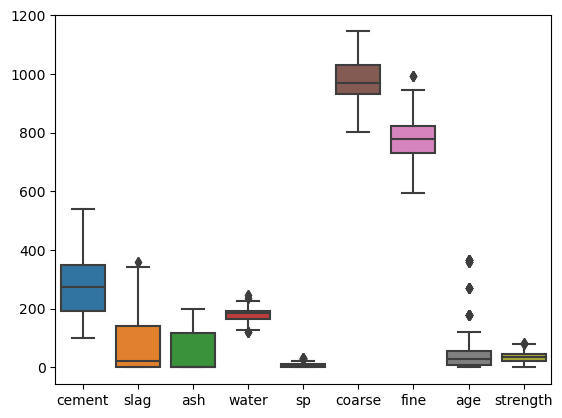

In [4]:
fig = sns.boxplot(data=df)
fig

A plot of the values of the columns in the dataset reveals no abnormalities. The coarse and fine aggregates are used as fillers in concrete in the place of more costly cement powder, hence the extremely high values of coarse and fine aggregates used. 

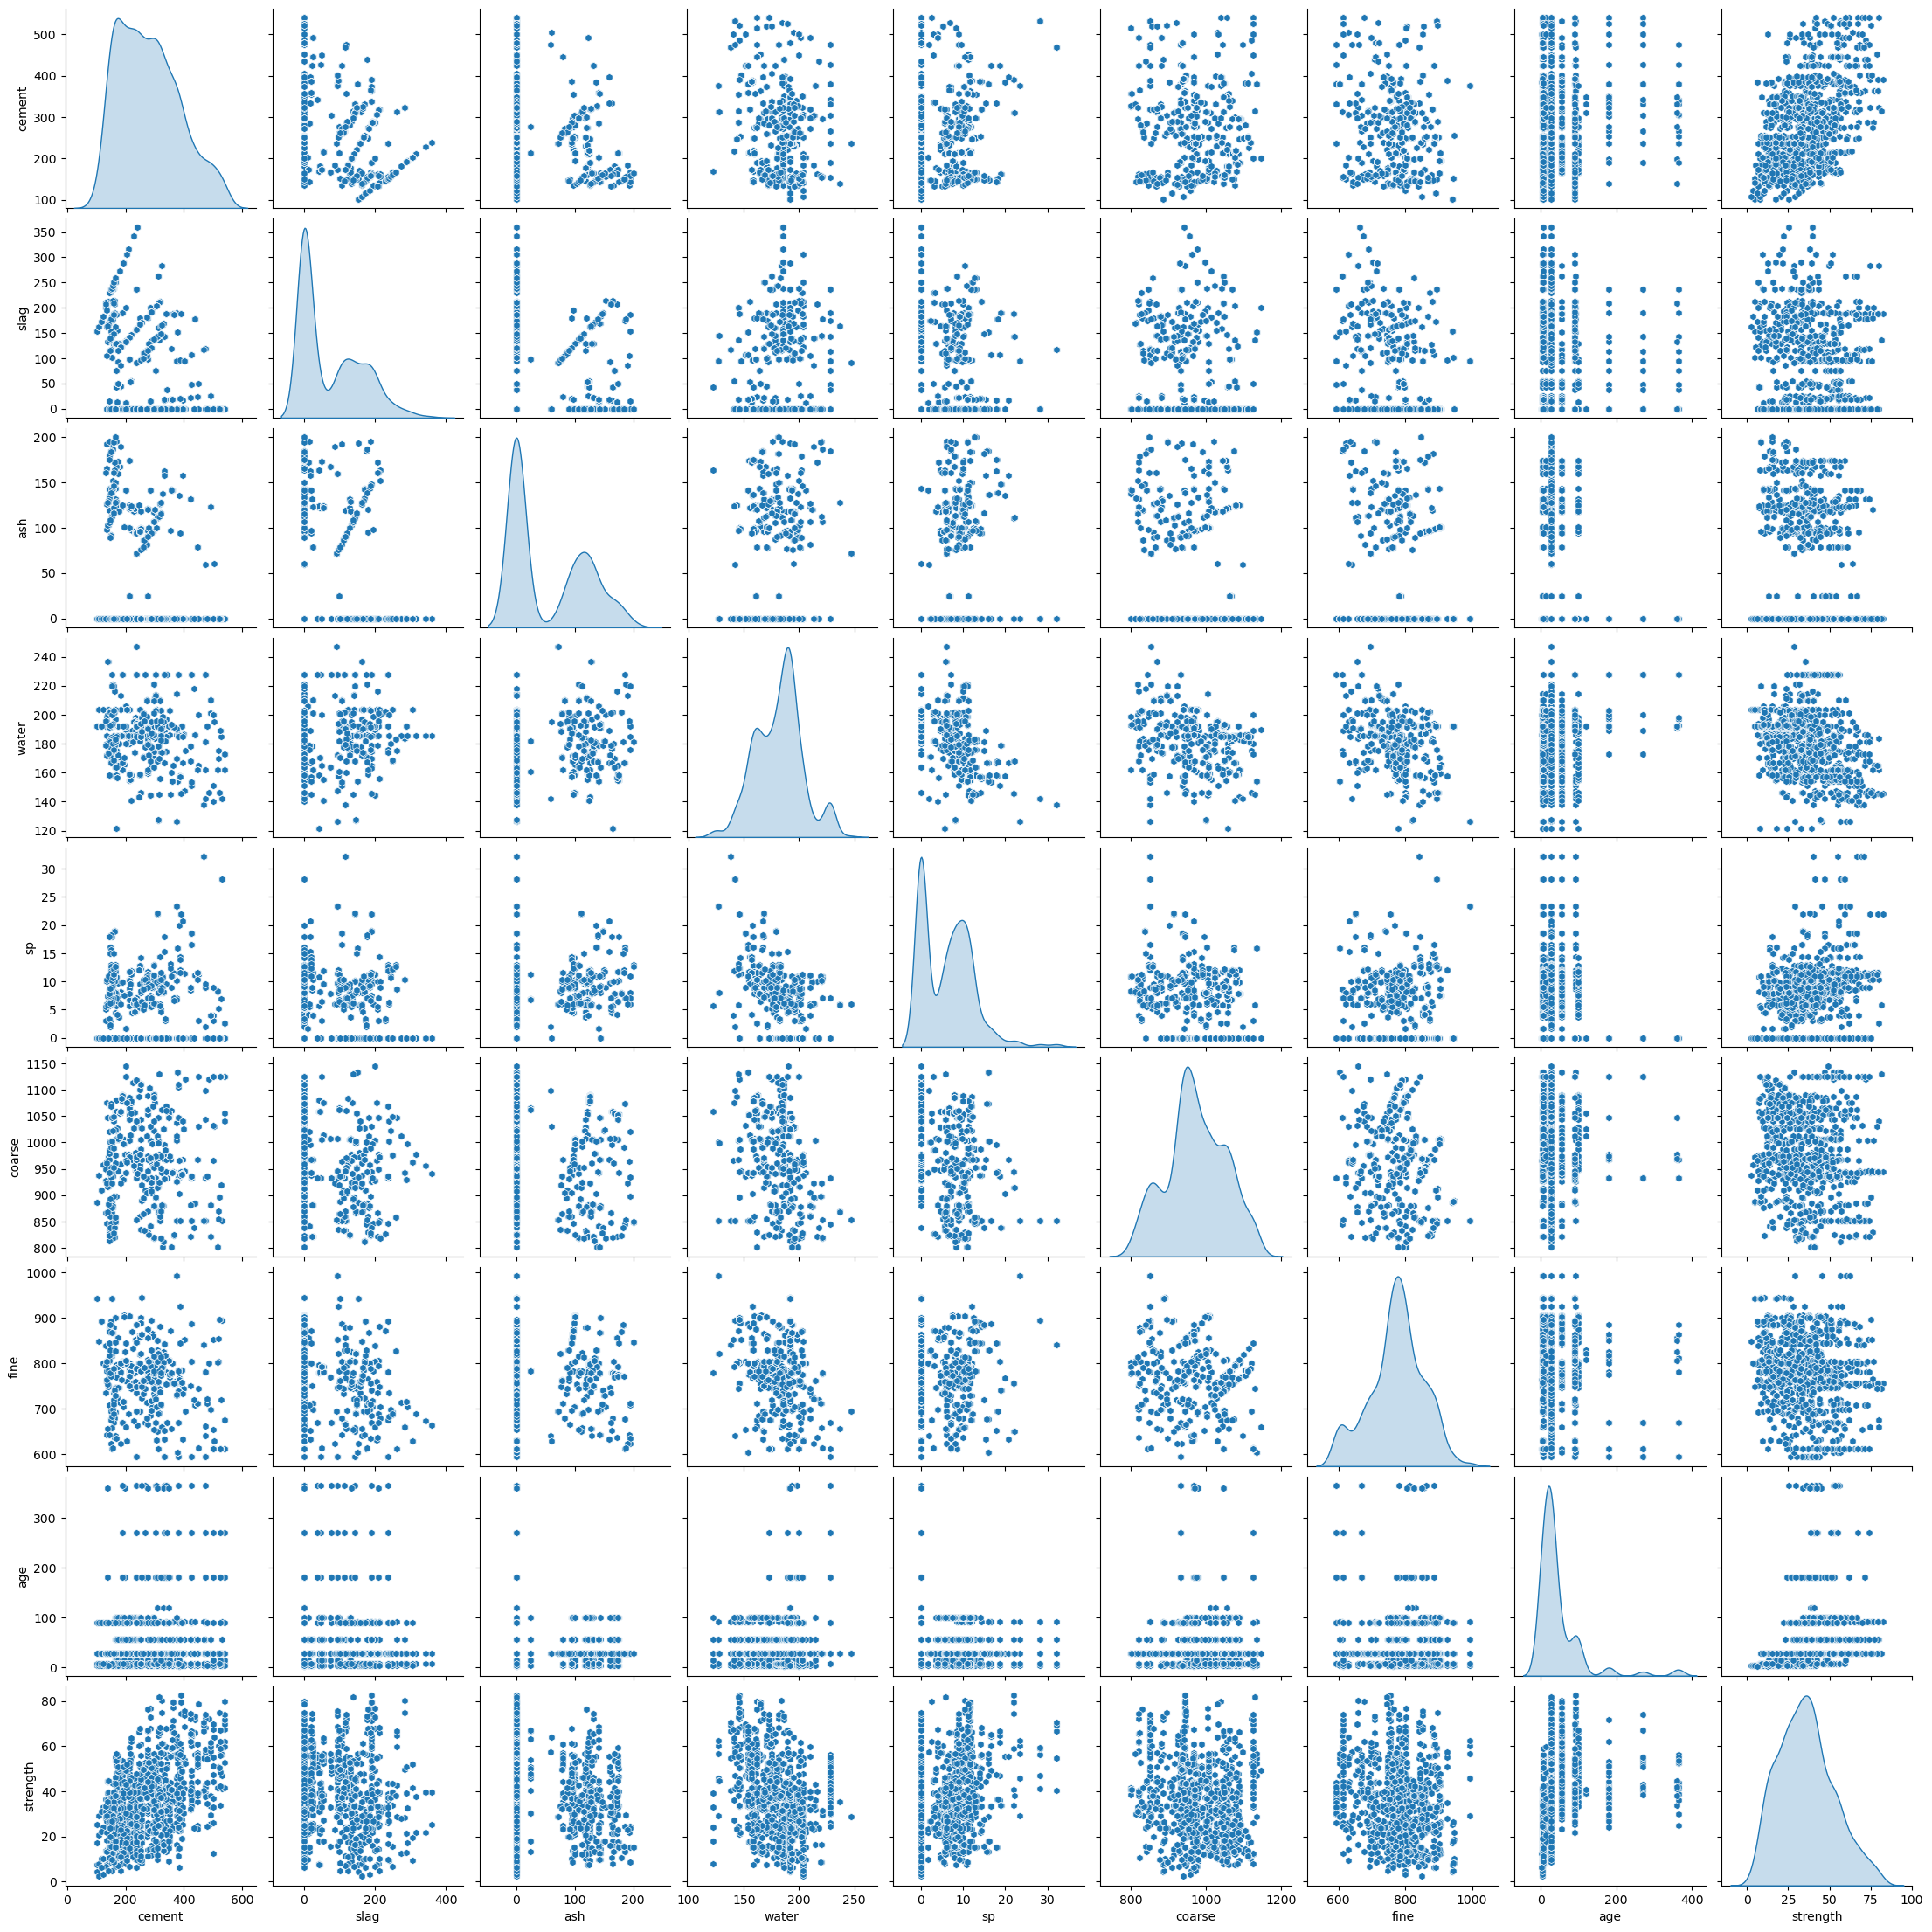

In [5]:
sns.pairplot(df,markers="h", diag_kind = 'kde')

A pairplot of the columns revealed several minor linear relationships between the amount of fly ash, blast furnace slag and cement powder. Fly ash and blast furnace slag are waste products of the incineration of municipal solid waste and the extraction of iron from iron ore respectively. The fly ash and blast furnace slag can sometimes be added together to make "green" concrete that is more environmentally friendly, however, this leads to a reduction in strength that is compensated by the increase in cement powder. It is, however, more common for "green" concrete to only use fly ash or blast furnace slag at any one time.

We can also see that there are minor linear relationships between the coarse and fine aggregates. Coarse and fine aggregates, as mentioned earlier, are used to bulk up the concrete so that it has a larger volume. However, the aggregates in the concrete will need to have a variety of sizes to maintain its strength. Too much coarse or too much fine aggregate will lead to a strength drop in the concrete.

Most columns in the dataset shows a normal distribution except for the blast furnace slag, fly ash and superplasticizer, which have bimodal distributions. This is because concrete mixes would either keep these ingredients at zero, or add them in amounts large enough to have a noticeable effect. Ingredients such as cement powder or water does not show this bimodal distribution as it is a core component of all concrete. 

***Due to the bimodal distibutions, it is possible that the data can be gathered in a few different clusters instead of being equally spread out. We can consider using K-means clustering to differentiate between the clusters and build different models for each cluster if we are unable to get a satisfactory accuracy.***

<Axes: >

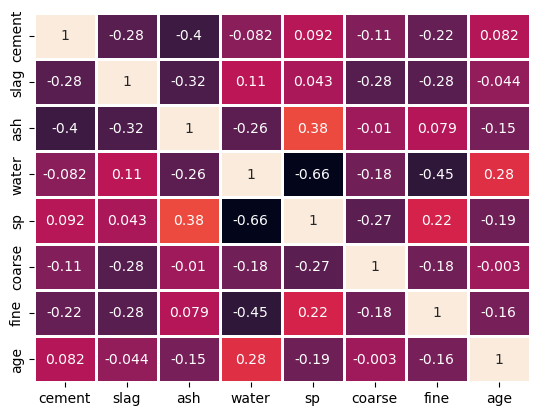

In [6]:
x = df.drop(['strength'],axis=1)
sns.heatmap(data = x.corr(), annot = True, fmt = '.2g', linewidths = 1, cbar = False)

We can see that there is a moderate negative correlation between the superplasticizer and the water used. Stronger concrete is usually made with lesser water, hoowever, the concrete made in this way usually does not flow well. In other words, the workability of the concrete will be bad. Superplasticizers are chemicals added to a mix so that the concrete will have increased workability. Thus, it is commonly used to increase the workability of a dryer concrete mix.

Fly ash and blast furnace slag also shows a moderate negative correlation. As mentioned earlier, concrete suppliers tend to use one or the other when making "green" concrete as it is troublesome to introduce additional variables when using a non-traditional ingredient such as fly ash or blast furnace slag.

Water also shows a moderate negative correlation to the amount of fine aggregates used, which is surprising. As the amount of fine aggregates increases, more water would need to be used to maintain the workability of the concrete. This could be due to superplasticizers that are also used in the mix.

***A heat map of the correlation shows the correlation of all the rows between two columns. The heat map may miss out on some relationships, such as the relationship between the fly ash, blast furnace slag and cement powder. The heat map needs to be read in conjunction with the scatter plot and distribution plot of the data above.***

In [8]:
scaler=sk.preprocessing.StandardScaler()

x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x ,df['strength'], test_size=0.2, random_state=88)

x_trainsk=scaler.fit_transform(x_train)
x_testsk=scaler.transform(x_test)


y_trainsk=pd.DataFrame(y_train)
y_testsk=pd.DataFrame(y_test)

y_trainsk=scaler.fit_transform(y_trainsk)
y_testsk=scaler.transform(y_testsk)

The independent variables and dependent variables are split into test and training sets. The test and training sets are then standardized for a Ridge regression from the SciKit Learn toolkit.

In [9]:
skreg=sk.linear_model.RidgeCV()
skreg.fit(x_trainsk, y_trainsk)
print('The R2 score for the RidgeCV regression from SciKit Learn is:',skreg.score(x_testsk, y_testsk))

The R2 score for the RidgeCV regression from SciKit Learn is: 0.6444620275507973


The R2 score for the RidgeCV regression model is around 0.644, which is not too impressive. We shall try running a XGBoost regression model next.

In [10]:
#xgb.cv is not used due to excessive runtime during the hyperopt later

reg=xgb.XGBRegressor()
reg.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

The non-standardized training set is used as XGBoost is a type of decision tree model, which does not require the input to be standardized as larger numerical values would not be weighted more heavily by the model.

In [11]:
kfold=sk.model_selection.KFold(n_splits=10, shuffle=True)

score=sk.model_selection.cross_val_score(reg, x_train, y_train,cv=kfold)
print('The R2 score for the XGB model is:',score.mean())

The R2 score for the XGB model is: 0.9109742061107038


The R2 score for the XGBoost regression model is 0.91, which is a lot better than the Ridge regression.

Next, we shall use Hyperopt to further fine-tune the model.

In [12]:
space = {
        'device':'cuda',
        'max_depth':hp.choice('max_depth', np.arange(4, 25, 1, dtype=int)),
        'n_estimators':hp.choice('n_estimators', np.arange(100, 10000, 10, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5 ,0.9, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(50, 350, 10, dtype=int)),
        'subsample':hp.quniform('subsample', 0.7, 0.9, 0.1),
        'learning_rate':hp.quniform('eta', 0.05, 0.3, 0.05),
        
        'objective':'reg:squarederror',
        
        'verbosity':0,

        'tree_method':'gpu_hist',
        'eval_metric': 'rmse',
    }

def score(params):
    model = xgb.XGBRegressor(**params)
    
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
              verbose=False, early_stopping_rounds=10)
    Y_pred = model.predict(x_test).clip(0, 20)
    score = np.sqrt(sk.metrics.mean_squared_error(y_test, Y_pred))
    print(score)
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize(trials, space):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=2000)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
print(space_eval(space, best_params))


24.37026477024769                                       
24.423790995169934                                                                 
24.219597102145208                                                                 
24.409020521349607                                                                
24.36789717376617                                                                 
24.266487855890567                                                                
24.409326306778915                                                                
24.316484639515927                                                                
24.328418916266383                                                                
24.420230882456075                                                                
24.317219795605087                                                                 
24.220682822146525                                                                 
24.34585649277424         

In [13]:
optparam=(space_eval(space, best_params))
regopt=xgb.XGBRegressor(**optparam)
print(regopt)
regopt.fit(x_train,y_train)
ypred=regopt.predict(x_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15000000000000002,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=50, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=8450, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [14]:
r2=sk.metrics.r2_score(y_test,ypred)
print('The R2 score for the XGB model with Hyperopt is',r2)

The R2 score for the XGB model with Hyperopt is 0.9431948986094633


The tuned XGBoost regression model has a R2 score of 0.94. 

Next, we shall attempt to find out which ingredient is the most important in deteermining the strength of the concrete.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

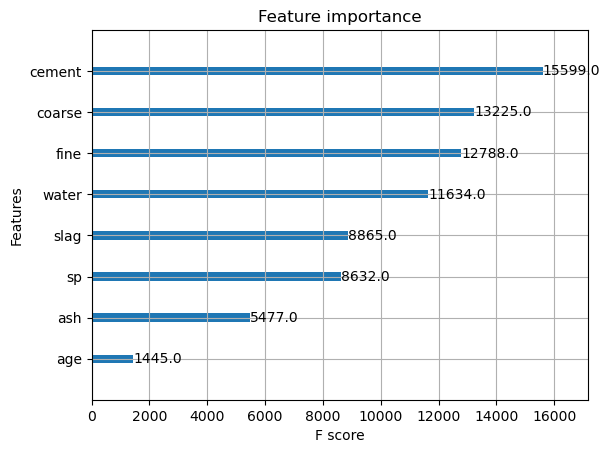

In [16]:
xgb.plot_importance(regopt)

As expected, the most important ingredient in determining the strength of a concrete mix is the amount of cement powder used in the mix while age is the least important factor.

As concrete develops around 70-80% of its strength within the first 7 days, and only have minute increases past 28 days, age would be a trivial factor in determining the age of the concrete.

We shall now use pickle to export the optimised XGBoost regression model parameters for use in a streamlit app.

In [18]:
import pickle

pickle.dump(regopt, open('regoptparams.pkl', 'wb'))